# 使用预训练的 convnet

In [1]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

np.random.seed(42)
tf.random.set_seed(42)

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

想要将 DL 应用于小型图像数据集，一种常用且非常高效的方法是使用预训练网络。

**<font color='red'>预训练网络 (pretrained network)</font>** 是一个保存好的网络，之前已在大型数据集 (通常是大规模图像分类任务) 上训练好。如果这个原始数据集足够大且足够通用，那么**预训练网络学到的特征的空间层次结构可以有效地作为视觉世界的通用模型**，因此这些特征可用于各种不同的计算机视觉问题，即使这些新问题涉及的类别和原始任务完全不同。

<font color='crimson'>预训练网络学到的特征在不同问题之间的可移植性，是 DL 与许多早期浅层学习方法相比的重要优势，它使得 DL 对小数据问题非常有效。</font>

这里将使用 VGG16 架构，其于 2014 年开发。

<br>

**<font color='blue'>使用预训练网络有 2 种方法：</font>**

- <font color='blue'>特征提取 (feature extraction)</font>


- <font color='blue'>微调模型 (fine-tuning)</font>

# 1. 特征提取 (feature extraction)

**<font color='crimson'>特征提取是使用之前网络学到的表示来从新样本中提取出有趣的特征。然后将这些特征输入一个新的分类器，从头开始训练。</font>**

<font color='blue'>用于图像分类的 convnet 包含 2 个部分：</font>

- 一系列的卷积层和池化层，称为模型的**<font color='red'>卷积基 (convolutional base)</font>**


- 密集连接分类器 (densely connected classifier)

**<font color='crimson'>对于 convnet 而言，特征提取就是取出之前训练好的网络的卷积基，在上面运行新数据，然后在输出上面训练一个新的分类器。</font>**

<div class="alert alert-block alert-info">
    <b><center>为什么仅重复使用卷积基，不重复使用密集连接分类器？</center></b><br>
    <b>卷积基学到的表示可能更加通用</b>，因此更适合重复使用。<b>convnet 的特征图表示通用概念在图像中是否存在，无论面对什么样的计算机视觉问题，这种特征图都可能很有用</b>。<br><br>
    但是，<b>分类器学到的表示必然是针对于模型训练的类别，其中仅包含某个类别出现在整张图像中的概率信息</b>。<br><br>
    此外，<b>密集连接层的表示不再包含物体在输入图像中的位置信息。密集连接层舍弃了空间的概念，而物体位置信息仍然由卷积特征图所描述。如果物体位置对于问题很重要，那么密集连接层的特征在很大程度上是无用的。</b>
</div>

**<font color='crimson'>某个卷积层提取的表示的通用性 (以及可复用性) 取决于该层在模型中的深度。</font>**

- **模型中更靠近底部的层提取的是局部的、高度通用的特征图** (比如视觉边缘、颜色和纹理)


- 而**更靠近顶部的层提取的是更加抽象的概念** (比如“猫耳朵”或“狗眼睛”)。


因此，<font color='crimson'>如果你的新数据集与原始模型训练的数据集有很大差异，那么最好只使用模型的前几层来做特征提取，而不是使用整个卷积基</font>。

这里，使用在 ImageNet 上训练的 VGG16 网络的卷积基从猫狗数据集中提取有趣的特征，然后在这些特征上训练一个猫狗分类器。

In [2]:
# Instantiate the VGG16 convolutional base
conv_base = tf.keras.applications.VGG16(
    weights='imagenet',  # 指定模型初始化的权重检查点
    # 指定模型最后是否包含密集连接分类器.
    # 默认情况下，这个密集连接分类器对应于 ImageNet 的 1000 个类别
    include_top=False,
    # 输入到网络中的图像张量的形状.
    # 可选参数. 如果为不传入，则网络可以处理任意 shape 的输入
    input_shape=(150, 150, 3))

In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [4]:
conv_base.output, conv_base.outputs

(<tf.Tensor 'block5_pool/Identity:0' shape=(None, 4, 4, 512) dtype=float32>,
 [<tf.Tensor 'block5_pool/Identity:0' shape=(None, 4, 4, 512) dtype=float32>])

In [5]:
conv_base.output_names, conv_base.output_shape

(['block5_pool'], (None, 4, 4, 512))

In [6]:
conv_base.input, conv_base.inputs, conv_base.input_names

(<tf.Tensor 'input_1:0' shape=(None, 150, 150, 3) dtype=float32>,
 [<tf.Tensor 'input_1:0' shape=(None, 150, 150, 3) dtype=float32>],
 ['input_1'])

接下来有 2 张方法可以选择：

- <font color='crimson'>1. 在数据集上运行卷积基 (`conv_base`)，将输出保存成硬盘中的 NumPy 数组，然后用这个数据作为输入，输入到独立的密集连接分类器中。</font>
  
  该方法**速度快，计算代价低**，因为**对于每个输入图像只需运行一次卷积基**，而卷积基是目前流程中计算代价最高的 (2017)。但出于同样的原因，<font color='crimson'>这种方法不允许使用数据增强</font>。


-  <font color='crimson'>2. 在顶部添加 Dense 层来扩展已有模型 (即 `conv_base`)，并在输入数据上端到端地运行整个模型。</font>

  <font color='crimson'>可以使用数据增强</font>，因为每个输入图像进入模型时都会经过卷积基。但出于同样的原因，这种方法的计算代价比第一种要高很多。

## 1.1 不使用数据增强的快速特征提取

首先将图像及其标签提取为 NumPy 数组，然后调用 `conv_base` 模型的 `predict` 方法来提取特征。

In [7]:
# Extract features using the pretrained convolutional base
base_dir = '/home/libing/datasets/dogs_vs_cats_small'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
batch_size = 32


def extract_features(dirctory, sample_count):
    # conv_base.output_shape: (None, 4, 4, 512)
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        dirctory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size:(i+1)*batch_size] = features_batch
        labels[i*batch_size:(i+1)*batch_size] = labels_batch

        # Python generator 在不断生成数据，所以必须在读取所有图像后停止
        i += 1
        if i*batch_size >= sample_count:
            break
    return features, labels


train_features, train_labels = extract_features(train_dir, 2000)
val_features, val_labels = extract_features(val_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
train_features.shape, train_labels.shape

((2000, 4, 4, 512), (2000,))

In [9]:
model = tf.keras.Sequential([
    # 提取的特征 shape 为 (samples, 4, 4, 512)，需要 flatten 为 (samples, 4*4*512)
    tf.keras.layers.Flatten(input_shape=(4, 4, 512)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(val_features, val_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 1ms/sample - loss: 0.6126 - acc: 0.6680 - val_loss: 0.4457 - val_acc: 0.8350
Epoch 2/30
2000/2000 [==============================] - 1s 380us/sample - loss: 0.4155 - acc: 0.8135 - val_loss: 0.3558 - val_acc: 0.8700
Epoch 3/30
2000/2000 [==============================] - 1s 430us/sample - loss: 0.3559 - acc: 0.8480 - val_loss: 0.3203 - val_acc: 0.8850
Epoch 4/30
2000/2000 [==============================] - 1s 372us/sample - loss: 0.3041 - acc: 0.8740 - val_loss: 0.2957 - val_acc: 0.8850
Epoch 5/30
2000/2000 [==============================] - 1s 359us/sample - loss: 0.2814 - acc: 0.8910 - val_loss: 0.2822 - val_acc: 0.8870
Epoch 6/30
2000/2000 [==============================] - 1s 342us/sample - loss: 0.2666 - acc: 0.8895 - val_loss: 0.2739 - val_acc: 0.8900
Epoch 7/30
2000/2000 [==============================] - 1s 335us/sample - loss: 0.2427 - acc: 0.9005 - val_loss: 0.2678 - val_

In [10]:
def plot_history(history):
    history_dict = history.history

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc = history_dict['acc']
    val_acc = history_dict['val_acc']

    epochs = [i + 1 for i in history.epoch]

    # Plot the results
    plt.figure(figsize=(14, 4.2))
    plt.subplot(121)
    plt.plot(epochs, loss_values, 'c+-', label='Training loss')
    plt.plot(epochs, val_loss_values, 'm.-', label='Val loss')
    plt.xlabel('Epochs', fontsize=12)
    plt.xticks(epochs, rotation=90)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=18)
    plt.title('Training and validation loss', fontsize=16)

    plt.subplot(122)
    plt.plot(epochs, acc, 'c+-', label='Training acc')
    plt.plot(epochs, val_acc, 'm.-', label='Val acc')
    plt.xlabel('Epochs', fontsize=12)
    plt.xticks(epochs, rotation=90)
    plt.ylabel('Acc', fontsize=12)
    plt.legend(fontsize=18)
    plt.title('Training and validation acc', fontsize=16)

    plt.show()

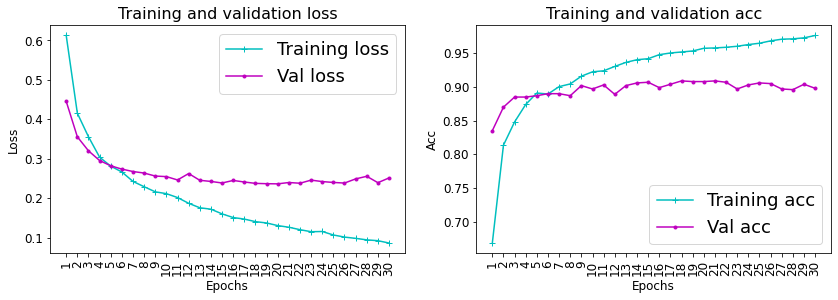

In [11]:
plot_history(history)

在验证集上的精度达到了 ~90%，比从头开始训练的小型模型好得多。

这里的模型仍然过拟合了。这是因为本方法没有使用数据增强，而数据增强对防止小型图像数据集的过拟合非常重要。

## 1.2 使用数据增强的特征提取

<font color='crimson'>在顶部添加 Dense 层来扩展已有模型 (即 `conv_base`)，并在输入数据上端到端地运行整个模型。</font>

这种方法速度更慢，计算代价更高，但在训练期间可以使用数据增强。这种方法就是：扩展 `conv_base` 模型，然后在输入数据上端到端地运行模型。

In [12]:
# Way 1
tf.keras.backend.clear_session()

x = conv_base.output
x = tf.keras.layers.Flatten()(x)
# 添加一个 Dense
x = tf.keras.layers.Dense(256, activation='relu')(x)
# 添加一个分类器
preds = tf.keras.layers.Dense(1, activation='sigmoid')(x)
# 完整模型
model = tf.keras.Model(inputs=conv_base.input, outputs=preds)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [13]:
len(model.layers)

22

In [14]:
# Way 2
tf.keras.backend.clear_session()

model = tf.keras.Sequential()
model.add(conv_base)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [15]:
len(model.layers)

4

**<font color='crimson'>在编译和训练模型之前，一定要“冻结”卷积基。冻结 (freeze) 一个或多个层是指在训练过程中保持其权重不变。如果不这么做，那么卷积基之前学到的表示将会在训练过程中被修改。因为其上添加的 Dense 层是随机初始化的，所以非常大的权重更新将会在网络中传播，对之前学到的表示造成很大破坏。</font>**

**冻结网络的方法是将其 `trainable` 属性设为 `False`。**

In [16]:
# trainable weights before freezing the conv base
len(model.trainable_weights)

30

In [17]:
# Freeze the conv base
conv_base.trainable = False

In [18]:
# trainable weights after freezing the conv base
len(model.trainable_weights)

4

In [19]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


此时，只有添加的 2 个 `Dense` 层的权重 (总共有 4 个权重张量，每层 2 个 (主权重矩阵和偏置向量)) 才会被训练。

**<font color='crimson'>为了让这些修改生效，必须先编译模型。如果在编译之后修改了权重的 trainable 属性，那么应该重新编译模型，否则这些修改将被忽略。</font>**

In [21]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
# The validation data should not be augmented!
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')
val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# 必须重新编译
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit_generator(
    train_generator,
    epochs=30,
    steps_per_epoch=2000//20,
    validation_data=val_generator,
    validation_steps=1000//20,
    verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 - 25s - loss: 0.6054 - acc: 0.6725 - val_loss: 0.4580 - val_acc: 0.8190
Epoch 2/30
100/100 - 24s - loss: 0.4757 - acc: 0.7905 - val_loss: 0.3819 - val_acc: 0.8550
Epoch 3/30
100/100 - 23s - loss: 0.4236 - acc: 0.8130 - val_loss: 0.3310 - val_acc: 0.8750
Epoch 4/30
100/100 - 23s - loss: 0.3990 - acc: 0.8230 - val_loss: 0.3298 - val_acc: 0.8450
Epoch 5/30
100/100 - 24s - loss: 0.3800 - acc: 0.8410 - val_loss: 0.2935 - val_acc: 0.8880
Epoch 6/30
100/100 - 24s - loss: 0.3676 - acc: 0.8325 - val_loss: 0.2883 - val_acc: 0.8840
Epoch 7/30
100/100 - 21s - loss: 0.3604 - acc: 0.8425 - val_loss: 0.2758 - val_acc: 0.8910
Epoch 8/30
100/100 - 24s - loss: 0.3446 - acc: 0.8465 - val_loss: 0.2722 - val_acc: 0.8820
Epoch 9/30
100/100 - 24s - loss: 0.3390 - acc: 0.8495 - val_loss: 0.2677 - val_acc: 0.8860
Epoch 10/30
100/100 - 24s - loss: 0.3479 - acc: 0.8505 - val_loss: 0.2899 - val_acc: 0.8670
Epoch

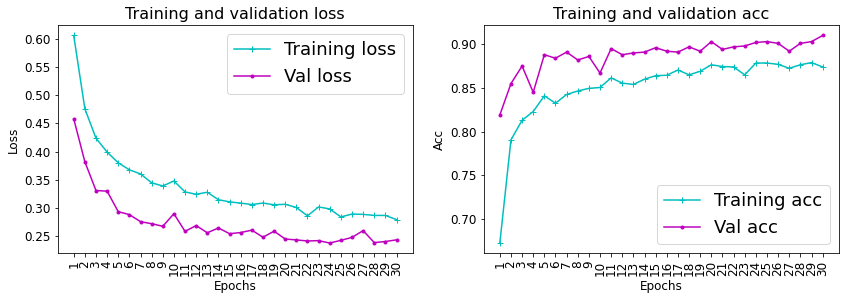

In [22]:
plot_history(history)

奇怪哦。按照书上参数，一直欠拟合。精度也没达到 ~96%。sad.

In [23]:
model.save('models/chap05-models/cats_and_dogs_small_3.h5')

# 2. Fine-tuning

模型微调 (fine-tuning)，与特征提取互为补充。

**<font color='crimson'>对于用于特征提取的冻结的模型基，微调是指将其顶部的几层“解冻”，并将这解冻的几层和新增加的部分 (本例中是全连接分类器) 联合训练。之所以叫作微调，是因为它只是略微调整了所复用模型中更加抽象的表示，以便让这些表示与手头的问题更加相关。</font>**

前面说过，冻结 VGG16 的卷积基是为了能够在上面训练一个随机初始化的分类器。同理，<font color='crimson'>只有上面的分类器已经训练好了，才能微调卷积基的顶部几层。如果分类器没有训练好，那么训练期间通过网络传播的误差信号会特别大，微调的几层之前学到的表示都会被破坏。</font>

因此，**<font color='blue'>微调网络的步骤如下:</font>**

1. 在已经训练好的基网络 (base network) 上添加自定义网络

2. 冻结基网络

3. 训练所添加的部分

4. 解冻基网络的一些层 (先解冻基网络，再冻结部分层)

5. 联合训练解冻的这些层和添加的部分


上面已经做到了第 3 步。

这里将微调最后三个卷积层，也就是说，直到 block4_pool 的所有层都应该被冻结，而 block5_conv1、block5_conv2 和 block5_conv3 三层应该是可训练的。

<div class="alert alert-block alert-info">
    <b><center>为什么不微调更多层?为什么不微调整个卷积基?</center></b><br>
    <b>1) 卷积基中更靠底部的层编码的是更加通用的可复用特征，而更靠顶部的层编码的是更专业化的特征。</b>微调这些更专业化的特征更加有用，因为它们需要在你的新问题上改变用途。<b>微调更靠底部的层，得到的回报会更少。</b><br><br>
    2) 训练的参数越多，过拟合的风险越大。卷积基有 1500 万个参数，所以在你的小型数据集上训练这么多参数是有风险的。
</div>

In [24]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [25]:
# 冻结直到某一层的所有层
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [26]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

<font color='crimson'>将使用学习率非常小的 RMSProp 优化器来实现。之所以让学习率很小，是因为对于微调的三层表示，我们希望其变化范围不要太大。太大的权重更新可能会破坏这些表示。</font>

In [27]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [29]:
history = model.fit_generator(
    train_generator,
    epochs=100,
    steps_per_epoch=2000//20,
    validation_data=val_generator,
    validation_steps=1000//20,
    verbose=2)

Epoch 1/100
100/100 - 22s - loss: 0.2846 - acc: 0.8770 - val_loss: 0.2361 - val_acc: 0.9080
Epoch 2/100
100/100 - 23s - loss: 0.2515 - acc: 0.8920 - val_loss: 0.2509 - val_acc: 0.8940
Epoch 3/100
100/100 - 23s - loss: 0.2363 - acc: 0.9030 - val_loss: 0.2017 - val_acc: 0.9130
Epoch 4/100
100/100 - 24s - loss: 0.2170 - acc: 0.9100 - val_loss: 0.1946 - val_acc: 0.9230
Epoch 5/100
100/100 - 24s - loss: 0.2158 - acc: 0.9105 - val_loss: 0.1919 - val_acc: 0.9160
Epoch 6/100
100/100 - 24s - loss: 0.1860 - acc: 0.9260 - val_loss: 0.1821 - val_acc: 0.9220
Epoch 7/100
100/100 - 23s - loss: 0.1729 - acc: 0.9290 - val_loss: 0.1905 - val_acc: 0.9230
Epoch 8/100
100/100 - 25s - loss: 0.1796 - acc: 0.9310 - val_loss: 0.2539 - val_acc: 0.9070
Epoch 9/100
100/100 - 24s - loss: 0.1650 - acc: 0.9315 - val_loss: 0.1957 - val_acc: 0.9270
Epoch 10/100
100/100 - 22s - loss: 0.1435 - acc: 0.9405 - val_loss: 0.2592 - val_acc: 0.9120
Epoch 11/100
100/100 - 22s - loss: 0.1530 - acc: 0.9430 - val_loss: 0.1785 - va

Epoch 95/100
100/100 - 24s - loss: 0.0192 - acc: 0.9945 - val_loss: 0.2763 - val_acc: 0.9370
Epoch 96/100
100/100 - 20s - loss: 0.0204 - acc: 0.9940 - val_loss: 0.3206 - val_acc: 0.9250
Epoch 97/100
100/100 - 23s - loss: 0.0224 - acc: 0.9940 - val_loss: 0.2854 - val_acc: 0.9350
Epoch 98/100
100/100 - 24s - loss: 0.0244 - acc: 0.9895 - val_loss: 0.2408 - val_acc: 0.9420
Epoch 99/100
100/100 - 24s - loss: 0.0152 - acc: 0.9950 - val_loss: 0.3952 - val_acc: 0.9200
Epoch 100/100
100/100 - 22s - loss: 0.0156 - acc: 0.9940 - val_loss: 0.3200 - val_acc: 0.9330


In [33]:
model.save('models/chap05-models/cats_and_dogs_small_4.h5')

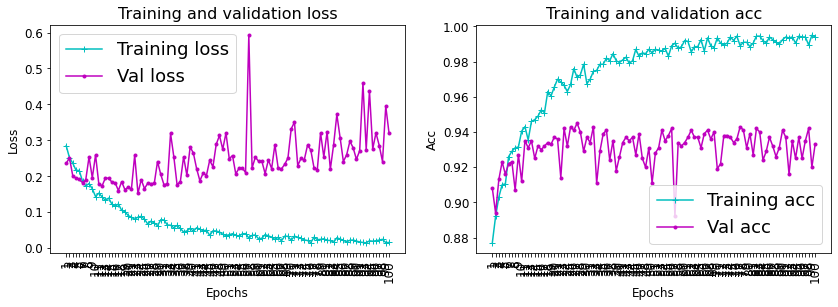

In [32]:
plot_history(history)

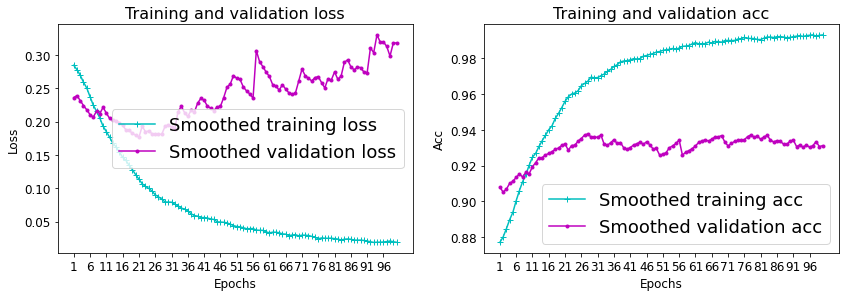

In [38]:
def smooth_curve(points, factor=0.8):
    """为了让图像更具可读性，可以将每个损失和精度都替换为指数移动平均值，从而让曲线变得平滑"""
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


epochs = [i + 1 for i in history.epoch]
plt.figure(figsize=(14, 4.2))
plt.subplot(121)
plt.plot(epochs, smooth_curve(history.history['loss']),
         'c+-', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(history.history['val_loss']),
         'm.-', label='Smoothed validation loss')
plt.xticks(np.arange(1, 101, 5))
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and validation loss')
plt.legend(fontsize=18)
plt.title('Training and validation loss', fontsize=16)

plt.subplot(122)
plt.plot(epochs, smooth_curve(history.history['acc']),
         'c+-', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(history.history['val_acc']),
         'm.-', label='Smoothed validation acc')
plt.xticks(np.arange(1, 101, 5))
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Acc', fontsize=12)
plt.title('Training and validation acc', fontsize=16)
plt.legend(fontsize=18)

plt.show()

In [39]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.929


后面的代码的结果已经偏离书中的结果了。知道思想即可。